<a href="https://colab.research.google.com/github/yuseifer/Outilier_detection_ESP8266_ThingSpeak/blob/main/Plantilla_analisis_ouliers_ThingSpeak_ESP8266.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt

# Configuración del canal ThingSpeak
CHANNEL_ID = "YOUR CHANNEL ID"
API_KEY = "YOUR READ API KEY"

df = None  # variable global para los datos descargados


In [4]:
#Si quieres filtrar por fechas descomenta la segunda línea y comenta la tercera, la fecha esta en el formato AAAA-MM-DDTHH:MM:SSZ. Yo filtré de 2025-09-07T20:16:45Z a 2025-09-07T20:32:48Z
#url=f'https://api.thingspeak.com/channels/3064297/feeds.json?api_key=A3AG62L2NSKKYRNT&start={2025-09-07T20:16:45Z}&end={2025-09-07T20:32:48Z}'
url=f'https://api.thingspeak.com/channels/{CHANNEL_ID}/feeds.json?api_key={API_KEY}'
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data['feeds'])
display(df)

,created_at,entry_id,field1,field2
0,2025-09-07T20:16:45Z,1,61,88
1,2025-09-07T20:17:01Z,2,56,85
2,2025-09-07T20:17:16Z,3,58,85
3,2025-09-07T20:17:32Z,4,55,86
4,2025-09-07T20:17:47Z,5,57,93
...,...,...,...,...
58,2025-09-07T20:31:46Z,59,211,76
59,2025-09-07T20:32:02Z,60,283,90
60,2025-09-07T20:32:17Z,61,306,108
61,2025-09-07T20:32:33Z,62,29,68


In [5]:
#Añadimos un preprocesado a los datos para normalizar las distancias
from sklearn.preprocessing import StandardScaler
df['field1'] = df['field1'].astype(float)
df['field2'] = df['field2'].astype(float)
scaler = StandardScaler()
df[['field1', 'field2']] = scaler.fit_transform(df[['field1', 'field2']])


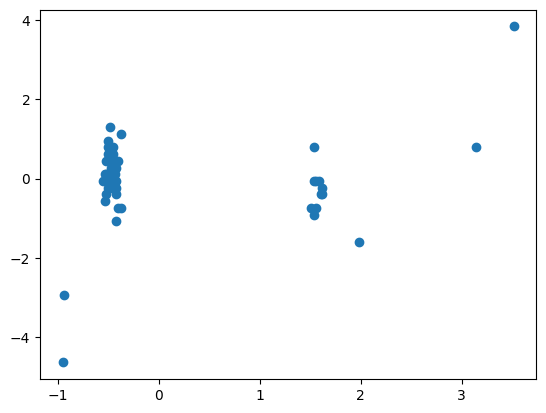

In [6]:
plt.scatter(x=df['field1'], y=df['field2'])

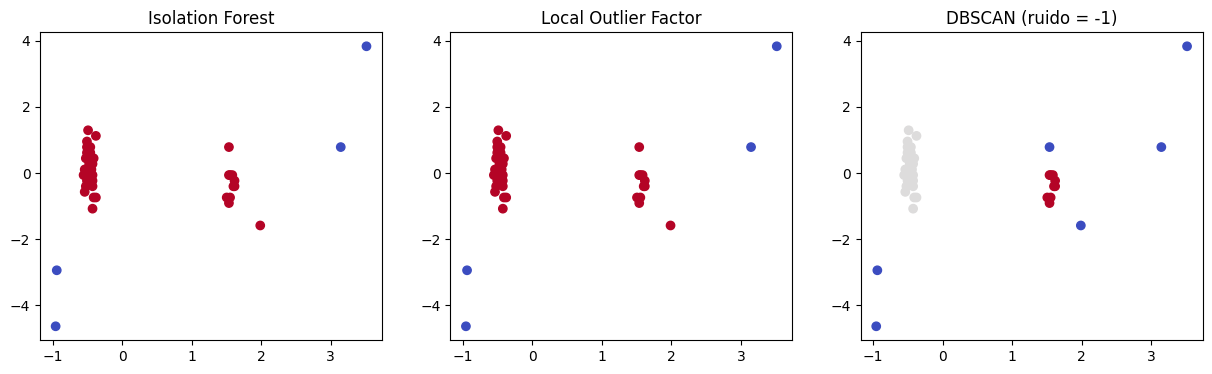

In [7]:
#Código para conexión de ESP32 con Python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

# ----------------------------
# 1. Crear datos sintéticos
# ----------------------------
X = df[['field1', 'field2']].values

# ----------------------------
# 2. Isolation Forest
# ----------------------------
iso = IsolationForest(contamination=0.05, random_state=42)
y_iso = iso.fit_predict(X)  # -1 = anomalía, 1 = normal

# ----------------------------
# 3. Local Outlier Factor
# ----------------------------
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_lof = lof.fit_predict(X)  # -1 = anomalía, 1 = normal

# ----------------------------
# 4. DBSCAN
# ----------------------------
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_db = dbscan.fit_predict(X)
# En DBSCAN: -1 = ruido (lo usamos como anomalía)

# ----------------------------
# 5. Visualización
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Isolation Forest
axes[0].scatter(X[:, 0], X[:, 1], c=y_iso, cmap="coolwarm")
axes[0].set_title("Isolation Forest")

# LOF
axes[1].scatter(X[:, 0], X[:, 1], c=y_lof, cmap="coolwarm")
axes[1].set_title("Local Outlier Factor")

# DBSCAN
axes[2].scatter(X[:, 0], X[:, 1], c=y_db, cmap="coolwarm")
axes[2].set_title("DBSCAN (ruido = -1)")

plt.show()


In [12]:
#Determinamos las clases y sus elementos para el algoritmo de DBSCAN
cuentas = np.unique(y_db, return_counts=True)
for i, j in zip(cuentas[0], cuentas[1]):
  if i == -1:
    print(f'Clase ruido: {j} elementos')
  else:
    print(f'Clase {i}: {j} elementos')




Clase ruido: 6 elementos
Clase 0: 48 elementos
Clase 1: 9 elementos


In [13]:
#Añadimos la columna de la clase a nuestro df para determinar las fechas en las que existieron fallos
df['clase'] = y_db
display(df)

,created_at,entry_id,field1,field2,clase
0,2025-09-07T20:16:45Z,1,-0.424397,0.446030,0
1,2025-09-07T20:17:01Z,2,-0.504784,-0.061799,0
2,2025-09-07T20:17:16Z,3,-0.472629,-0.061799,0
3,2025-09-07T20:17:32Z,4,-0.520862,0.107477,0
4,2025-09-07T20:17:47Z,5,-0.488707,1.292413,0
...,...,...,...,...,...
58,2025-09-07T20:31:46Z,59,1.987238,-1.585289,-1
59,2025-09-07T20:32:02Z,60,3.144822,0.784583,-1
60,2025-09-07T20:32:17Z,61,3.514606,3.831562,-1
61,2025-09-07T20:32:33Z,62,-0.938879,-2.939501,-1


In [14]:
#Mostramos las fechas donde existieron fallos
df[df['clase'] == -1]

,created_at,entry_id,field1,field2,clase
57,2025-09-07T20:31:31Z,58,1.537066,0.784583,-1
58,2025-09-07T20:31:46Z,59,1.987238,-1.585289,-1
59,2025-09-07T20:32:02Z,60,3.144822,0.784583,-1
60,2025-09-07T20:32:17Z,61,3.514606,3.831562,-1
61,2025-09-07T20:32:33Z,62,-0.938879,-2.939501,-1
62,2025-09-07T20:32:48Z,63,-0.954956,-4.632267,-1


Con base a los grupos creados por el algoritmo de DBSCAN, vamos a tener 3 grupos los cuáles el -1 es para el ruido, el 0 para los datos comunes y otro grupo de 1 que el algoritmo determino como otro grupo. Según se quiera hacer el análisis en el caso de trabajar con una planta que fabrica 2 productos, según la clase dada tendríamos: ruido (-1), producto 1 (0) y producto 2 (1). Pero en el caso de que solo se tenga un solo producto el grupo con identificador 1 debe tratarse como ruido o como alguna anomalía en la línea de producción